In [33]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import random
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import activations
from tensorflow.keras import losses
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.layers import LSTM, TimeDistributed, Permute, Reshape

ModuleNotFoundError: No module named 'keras'

In [2]:
files = glob.glob('project 4 training/training2017/A0[0-9][0-9][0-9][0-9].mat', recursive = True)
mat_list = []
for file in files:
    mat = loadmat(file)
    mat_list.append(mat)

In [3]:
labels = pd.read_csv('REFERENCE.csv', header=None, index_col=False,)

In [4]:
ecg_list = []
for mat in mat_list:
    dum = mat['val'].reshape((-1))
    ecg_list.append(dum)

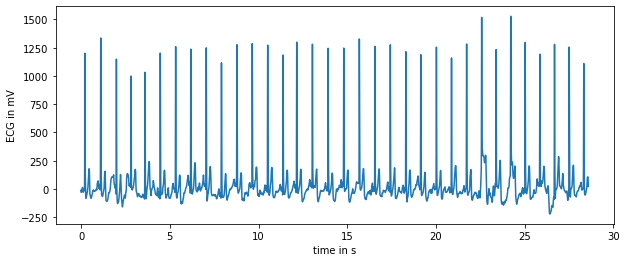

In [5]:
f = plt.figure()
f.set_figwidth(10)
fs = 360

ecg = random.choice(ecg_list)

time = np.arange(ecg.size) / fs
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.show()

<AxesSubplot:xlabel='1', ylabel='count'>

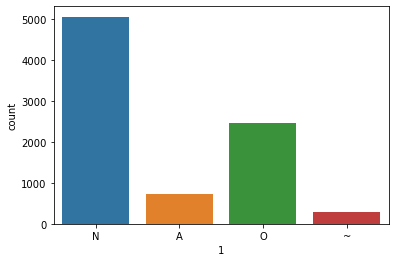

In [6]:
sns.countplot(x = labels[1])

In [7]:
print(len(min(ecg_list, key = len)))

2714


In [8]:
len(ecg_list[0])

9000

# Change all the ecg's to the shortest length 
issues that could happen: maybe too short and lead to incorrect classification because irregularity might happen later in the ecg

In [9]:
modified_ecg = []

for ecg in ecg_list:
    dum = ecg[:2714]
    modified_ecg.append(dum)

In [10]:
len(modified_ecg[0])

2714

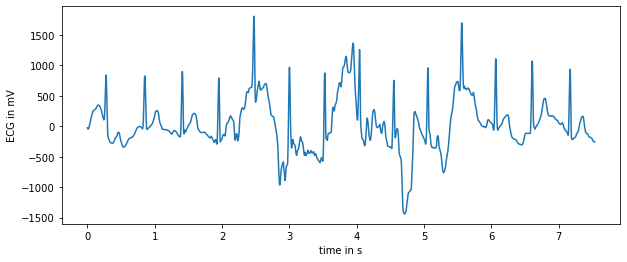

In [11]:
f = plt.figure()
f.set_figwidth(10)
fs = 360

ecg = random.choice(modified_ecg)

time = np.arange(ecg.size) / fs
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.show()

# Reading the Labels and Test/Train Split

In [12]:
labels = pd.read_csv('REFERENCE.csv', header=None, index_col=False,)
labels.reset_index()
labels = labels.drop(0, axis = 1)

df = pd.DataFrame()

conditions = [
    (labels[1] == 'N'),
    (labels[1] == 'A'),
    (labels[1] == 'O'),
    (labels[1] == '~')
]
values = [0, 1, 2, 3]

df['labels'] = np.select(conditions, values)
df.to_numpy()

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [13]:
x_train, x_test, y_train, y_test = train_test_split(modified_ecg, df, test_size=0.25, random_state=42)
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

In [14]:
new_x_train = np.expand_dims(np.random.normal(size= (6396, 2714)), axis = -1)
new_x_test = np.expand_dims(np.random.normal(size= (6396, 2714)), axis = -1)

In [15]:
new_x_train = np.reshape(a = x_train, newshape = ((6396, 2714, 1)))
new_x_test = np.reshape(a = x_test, newshape = ((2132, 2714, 1)))

# Making the model

In [16]:
model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape = x_train[0].shape))

model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))

model.add(layers.Dense(4, activation=tf.keras.activations.softmax))
model.compile(loss='categorical_hinge', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
# FITTING
history = model.fit(x = x_train, y = y_train, batch_size = 128, steps_per_epoch = None, epochs=10, verbose = 0)
avg_acc = 0
avg_loss = 0
for i, k in zip(history.history['loss'], history.history['acc']):
    avg_loss = i + avg_loss
    avg_acc = k + avg_acc

print("Training Info")
print('avg_loss = ', avg_loss / len(history.history['loss']))
print('avg_acc = ', avg_acc / len(history.history['acc']))
print("min loss: ", min(history.history['loss']))
print("max acc: ", max(history.history['acc']))
print("\n")

# PREDICTING
results = model.evaluate(x_train, y_train, batch_size = 128, steps = 1)
predictions = model.predict(x_test, steps = 1)
print("predictions shape:", predictions.shape)
new_pred = []
pred = predictions.tolist()
for i in pred:
    new_pred.append(i.index(max(i)))

print("Evalution Info")
print("Accuracy Score: ", accuracy_score(new_pred, y_test))
print("Confusion Matrix: \n", confusion_matrix(new_pred, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2023-05-26 10:56:42.956141: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2023-05-26 10:56:42.986421: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2600000000 Hz
2023-05-26 10:56:42.989357: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5598b6041080 executing computations on platform Host. Devices:
2023-05-26 10:56:42.989682: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2023-05-26 10:56:43.007593: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2023-05-26 10:56:44.448055: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5598b8258f00 executing computations on platform CUDA. Devices:
2023-05-26 10:56:44.448105: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device 

Training Info
avg_loss =  0.7431692063212021
avg_acc =  0.24990619271993636
min loss:  0.7351984585576538
max acc:  0.28064415


1/1 [==============================] - 0s 138ms/step - loss: 0.7351 - acc: 0.0163
predictions shape: (2132, 4)
Evalution Info
Accuracy Score:  0.19277673545966229
Confusion Matrix: 
 [[ 12   3   8   1]
 [525  63 246  33]
 [741 114 336  30]
 [ 14   0   6   0]]


In [18]:
# not working for some reason? just copy paste 
k_models = []

#################### Base Model ############################

model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape = x_train[0].shape))
model.add(layers.Dense(4, activation=tf.keras.activations.softmax))
model.compile(loss='categorical_hinge', optimizer='adam', metrics=['accuracy'])

k_models.append(model)

#################### 2 Layers 32 each ############################

model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape = x_train[0].shape))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(4, activation=tf.keras.activations.softmax))
model.compile(loss='categorical_hinge', optimizer='adam', metrics=['accuracy'])

k_models.append(model)

#################### More layers less in each Layers ############################

model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape = x_train[0].shape))

model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))

model.add(layers.Dense(4, activation=tf.keras.activations.softmax))
model.compile(loss='categorical_hinge', optimizer='adam', metrics=['accuracy'])

k_models.append(model)

In [19]:
conv_models = []
shape = (6396, 2714)
#################### Convolutional Base ############################

model = models.Sequential()
model.add(layers.Conv1D(1, (1), activation='relu', input_shape=new_x_train[0].shape))

# issues with incompatible shapes [128,2714] vs. [128]
# model.add(layers.MaxPooling1D((1)))

model.add(tf.keras.layers.GlobalAveragePooling1D())

model.add(layers.Dense(10, activation=tf.keras.activations.softmax))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

conv_models.append(model)

#################### Convolutional Tweak ############################

model = models.Sequential()
model.add(layers.Conv1D(1, (1), activation='relu', input_shape=new_x_train[0].shape))

# issues with incompatible shapes [128,2714] vs. [128]
# model.add(layers.MaxPooling1D((1)))
model.add(tf.keras.layers.GlobalAveragePooling1D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(10, activation=tf.keras.activations.softmax))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

conv_models.append(model)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2714, 1)           2         
_________________________________________________________________
global_average_pooling1d (Gl (None, 1)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                20        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2714, 1)           2         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 1)                 0         
____________________________________

In [20]:
model = models.Sequential()
model.add(layers.Conv1D(4, (1), activation='relu', input_shape=new_x_train[0].shape))

# issues with incompatible shapes [128,2714] vs. [128]
# model.add(layers.MaxPooling1D((1)))
model.add(tf.keras.layers.GlobalAveragePooling1D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(10, activation=tf.keras.activations.softmax))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2714, 4)           8         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 4)                 0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_32 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_33 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_34 (Dense)             (None, 10)                330       
Total params: 2,610
Trainable params: 2,610
Non-trainable params: 0
____________________________________________________

In [21]:
# FITTING
history = model.fit(x = new_x_train, y = y_train, batch_size = 128, steps_per_epoch = None, epochs=10, verbose = 0)
avg_acc = 0
avg_loss = 0
for i, k in zip(history.history['loss'], history.history['acc']):
    avg_loss = i + avg_loss
    avg_acc = k + avg_acc

print("Training Info")
print('avg_loss = ', avg_loss / len(history.history['loss']))
print('avg_acc = ', avg_acc / len(history.history['acc']))
print("min loss: ", min(history.history['loss']))
print("max acc: ", max(history.history['acc']))
print("\n")

# PREDICTING
results = model.evaluate(new_x_test, y_test, batch_size = 128, steps = 1)
predictions = model.predict(new_x_test, steps = 1)
print("predictions shape:", predictions.shape)
new_pred = []
pred = predictions.tolist()
for i in pred:
    new_pred.append(i.index(max(i)))

print("Evalution Info")
print("Accuracy Score: ", accuracy_score(new_pred, y_test))
print("Confusion Matrix: \n", confusion_matrix(new_pred, y_test))

2023-05-26 10:56:52.951425: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudnn.so.7


Training Info
avg_loss =  1.375970443619125
avg_acc =  0.5802532851696014
min loss:  1.053530822178958
max acc:  0.5906817


1/1 [==============================] - 0s 89ms/step - loss: 1.0322 - acc: 0.6023
predictions shape: (2132, 10)
Evalution Info
Accuracy Score:  0.6022514071294559
Confusion Matrix: 
 [[1242  174  554   60]
 [   0    0    0    0]
 [  50    6   42    4]
 [   0    0    0    0]]


In [31]:
# create baseline LSTM model


baseline_rnn = Sequential()

baseline_rnn.add(InputLayer(input_shape=(215,333,3)))
baseline_rnn.add(Permute((2,1,3)))
baseline_rnn.add(Reshape((333, 215*3)))

baseline_rnn.add(LSTM(units=64, return_sequences=False))
baseline_rnn.add(Dense(units = 32, activation='relu'))
baseline_rnn.add(Dense(units = 10, activation='softmax'))

baseline_rnn.summary()

ModuleNotFoundError: No module named 'keras'